C:\Users\hp\AppData\Local\Temp\ipykernel_16656\1939332626.py:4: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import label


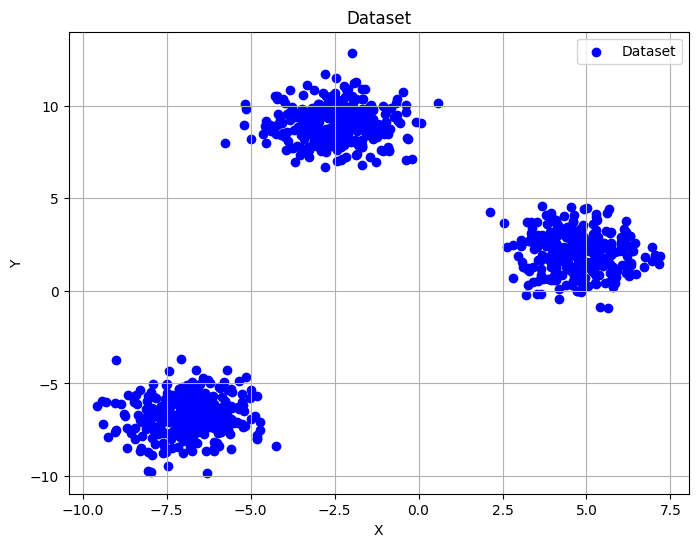

Count Matrix M:
[[ 0  3  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 10 18  6  3  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 4 17 47 39 12  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7 20 41 34  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  8 20 17  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  4  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  4 12 26 13  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  6 31 46 19  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9 31 50 23  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  4 14 14  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  2  3  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  4  1  2  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  6 21 25  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  

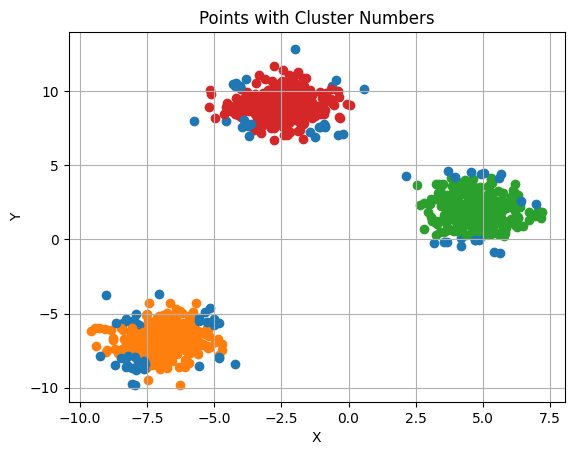

total_distance :
15
dissimilarity :
0.9375


In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
import math
import random
import pickle
# from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive')
file_path1 = './blobs_dataset.pkl'
file_path2 = './number.txt'
file_path3 = './label_sets.pkl'


# PrivTHR
################################################################################
def laplacian_mechanism(matrix, epsilon):
    noisy_matrix = np.zeros_like(matrix)
    rows, cols = matrix.shape
    sensitivity = 1.0  # Sensitivity of adding Laplacian noise to each cell

    for i in range(rows):
        for j in range(cols):
            laplace_noise = np.random.laplace(loc=0, scale=sensitivity / epsilon)
            noisy_matrix[i, j] = matrix[i, j] + laplace_noise

    return noisy_matrix



################################################################################


def haar_wavelet_transform(matrix):
    coeffs = pywt.dwt2(matrix, 'haar')
    cA, (cH, cV, cD) = coeffs
    return cA

def map_cells(original_matrix):
    mapped_cells = {}
    for i in range(original_matrix.shape[0]):
        for j in range(original_matrix.shape[1]):
            # Determine the corresponding cell in the output matrix
            output_i = i // 2
            output_j = j // 2
            # Update the mapping dictionary
            output_cell = (output_i, output_j)
            if output_cell in mapped_cells:
                mapped_cells[output_cell].append((i, j))
            else:
                mapped_cells[output_cell] = [(i, j)]
    return mapped_cells


def get_threshold(p, epsilon, matrix):
    positive_nums = []
    for row in matrix:
        for element in row:
            if element > 0:
                positive_nums.append(element)
    positive_nums.sort()

    m = len(positive_nums)
    print("size of L:")
    print(m)
    k= (int)((1-p)*m)
    probabilities = []
    probabilities.append((positive_nums[0])*(math.exp(-0.5*epsilon*abs(m-k))))
    for i in range(1, m):
        probabilities.append((positive_nums[i]-positive_nums[i-1])*(math.exp(-0.5*epsilon*abs(m-i-k))))

    if not math.isclose(sum(probabilities), 1):
        # Proportionally scale probabilities to sum up to 1
        total_prob = sum(probabilities)
        probabilities = [prob / total_prob for prob in probabilities]

    # Use random.choices to select a number based on the given probabilities
    selected_number = random.choices(positive_nums, weights=probabilities, k=1)[0]

    # Get the index of the selected number
    selected_index = positive_nums.index(selected_number)
    other_number=0
    if(selected_index>0):
        other_number=positive_nums[selected_index-1]

    _d=random.uniform(other_number, selected_number)
    return _d







def identify_significant_grids(average_subband_matrix, threshold):
    # Identify significant grids based on the threshold
    significant_grids = average_subband_matrix > threshold
    return significant_grids

def label_clusters(significant_grids):
    # Use connected component analysis to label clusters
    labeled_matrix, num_clusters = label(significant_grids)
    return labeled_matrix, num_clusters

def map_clusters_to_original_cells(mapped_cells, labeled_matrix):
    # Assign cluster numbers to the cells in the original input matrix
    clustered_matrix = np.zeros_like(M)
    for output_cell, original_cells in mapped_cells.items():
        for original_cell in original_cells:
            clustered_matrix[original_cell] = labeled_matrix[output_cell]
    return clustered_matrix






################################################################################





def quantize_dataset(dataset, grid_size):
    """
    Quantize the feature space of a dataset into grids of a specified size.

    Parameters:
    - dataset (np.ndarray): Array representing the dataset.
    - grid_size (float): Size of each grid.

    Returns:
    - np.ndarray: Count matrix M representing the quantized feature space.
    - dict: A dictionary mapping grid cell indices to the input points belonging to that cell.
    """
    # Determine the number of grids in each dimension
    x_min, y_min = np.min(dataset, axis=0)
    x_max, y_max = np.max(dataset, axis=0)
    num_x_grids = int(np.ceil((x_max - x_min) / grid_size))
    num_y_grids = int(np.ceil((y_max - y_min) / grid_size))

    # Initialize count matrix M
    M = np.zeros((num_y_grids, num_x_grids), dtype=int)

    # Initialize dictionary to store mapping of grid cells to input points
    cell_map = {}

    # Quantize dataset into grids
    for index, point in enumerate(dataset):
        x_index = int((point[0] - x_min) / grid_size)
        y_index = int((point[1] - y_min) / grid_size)
        cell_index = (x_index, y_index)
        M[y_index, x_index] += 1
        if cell_index not in cell_map:
            cell_map[cell_index] = []
        cell_map[cell_index].append(point)

    return M, cell_map

# Parameters
num_samples = 1000
num_clusters = 3
cluster_std = 1.0
grid_size = 1.0
epsilon=2.0
alpha=0.7

# Load the dataset from the file
with open(file_path1, 'rb') as file:
    dataset = pickle.load(file)

# Quantize dataset into grids and get cell map
M, cell_map = quantize_dataset(dataset, grid_size)

# Plot dataset
plt.figure(figsize=(8, 6))
plt.scatter(dataset[:, 0], dataset[:, 1], color='blue', label='Dataset')
plt.title('Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

# Output the count matrix
print("Count Matrix M:")
print(M)

original_M=M;
original_W=haar_wavelet_transform(original_M)

# Applying PrivTHR
M=laplacian_mechanism(M, alpha*epsilon)

print("Count matrix after PrivQT:")
print(M)

# Output the map
# print("\nMapping of Grid Cells to Input Points:")
# for cell_index, points in cell_map.items():
#     print(f"Cell {cell_index}: {points}")


################################################################################


# Step 1: Apply Haar wavelet transform and retrieve average subband matrix
average_subband_matrix = haar_wavelet_transform(M)

# Output average subband matrix
print("Average Subband Matrix:")
print(average_subband_matrix)

# Step 2: Map each cell of the output matrix to the cells of the original matrix
mapped_cells = map_cells(M)

# Step 3: Define a threshold
# threshold = 10  # Adjust the threshold as needed
threshold=get_threshold(0.4, (1-alpha)*epsilon, original_W)
print("threshold:")
print(threshold)


# Step 4: Identify significant grids
significant_grids = identify_significant_grids(average_subband_matrix, threshold)

# Step 5: Label clusters using connected component analysis
labeled_matrix, num_clusters = label_clusters(significant_grids)

# Step 6: Map cluster numbers to original cells
clustered_matrix = map_clusters_to_original_cells(mapped_cells, labeled_matrix)

print("\nClustered Matrix:")
print(clustered_matrix)


################################################################################


# # Print cell map
# print("\nCell Map:")
# for cell_index, points in cell_map.items():
#     print(f"Cell {cell_index}: {len(points)} points")

# Generate cluster numbers matrix W
W = clustered_matrix

# Assign cluster numbers to each point in the cell map
clustered_points = []
for cell_index, points in cell_map.items():
    cluster_number = W[cell_index[1], cell_index[0]]  # cell_index order is (y_index, x_index)
    clustered_points.extend([(point, cluster_number) for point in points])

# Plot points with cluster numbers
# plt.figure(figsize=(8, 6))
for point, cluster_number in clustered_points:
    x, y = point
    plt.scatter(x, y, color=plt.cm.tab10(cluster_number), label=f'Cluster {cluster_number}')

plt.title('Points with Cluster Numbers')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
# plt.legend()
plt.show()


################################################################################

# Dictionary to store sets for each label
label_sets = {}

# Iterate through the points and labels
for point, label in clustered_points:
    if label != 0:
        # Check if the label already exists in the dictionary
        if label in label_sets:
            # If label exists, add the point to its corresponding set
            label_sets[label].add(tuple(point))
        else:
            # If label doesn't exist, create a new set with the point
            label_sets[label] = {tuple(point)}



# Load the dictionary from the file
with open(file_path3, 'rb') as file:
    original_label_sets = pickle.load(file)

# Read the number from the file
with open(file_path2, 'r') as file:
    count_of_significant_grids = float(file.read())

# for label, point_set in original_label_sets.items():
#     print(f"Points for label '{label}': {point_set}")


total_distance = 0
if(len(label_sets) == len(original_label_sets)):
    for i in range(1, len(label_sets)):
        if i in label_sets and i in original_label_sets:
            difference1 = len(label_sets[i]-original_label_sets[i])
            difference2 = len(original_label_sets[i]-label_sets[i])
            total_distance += max(difference1, difference2)


print("total_distance :")
print(total_distance)


dissimilarity = total_distance/count_of_significant_grids

print("dissimilarity :")
print(dissimilarity)


